In [1]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap
import aggmap

warnings.filterwarnings("ignore")


In [2]:
from config import P

In [3]:
seed = P.seed #for the random permutation
metric = P.metric  # similarity measurement
var_thr = P.var_thr  # feature variance should larger than 0


color_list = P.color_list
mnist_labels_dict = P.mnist_labels_dict
data_save_folder = P.mnist_data_save_folder


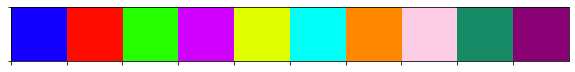

In [4]:
sns.palplot(color_list)

In [5]:
if not os.path.exists(data_save_folder):
    os.makedirs(data_save_folder)

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #(x_train, y_train), (x_test, y_test)

## 1) orignal(c=1): OR1

In [7]:
## 1) orignal(c=1): OR1
_, w, h = x_train.shape
trainX_OR1 = x_train.reshape(x_train.shape[0], w, h, 1)
testX_OR1 = x_test.reshape(x_test.shape[0], w, h, 1)

dump((trainX_OR1, testX_OR1),  os.path.join(data_save_folder, '01_X_OR1.data')) 

['/raid/shenwanxiang/aggmap/mnist/correlation/01_X_OR1.data']

# A. shuffle

In [8]:
orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], w*h), columns = orignal_cols)
shuffled_cols = shuffle(orignal_cols, random_state=seed)
x_train_df = x_train_df[shuffled_cols]
x_test_df = x_test_df[shuffled_cols]

## 2) ORS1: 

In [9]:
## 2) shuffle(c=1): ORS1
trainX_ORS1 = x_train_df.values.reshape(-1, w, h, 1)
testX_ORS1 = x_test_df.values.reshape(-1, w, h, 1)
dump((trainX_ORS1, testX_ORS1),  os.path.join(data_save_folder, '02_X_ORS1.data')) 

['/raid/shenwanxiang/aggmap/mnist/correlation/02_X_ORS1.data']

In [10]:
mp_train = AggMap(x_train_df, metric = metric)
mp_test = AggMap(x_test_df, metric = metric)

mp_train.save(os.path.join(data_save_folder, 'train.mp'))
mp_test.save(os.path.join(data_save_folder, 'test.mp'))

2020-10-16 22:58:05,401 - INFO - [bidd-aggmap] - Calculating distance ...
2020-10-16 22:58:05,438 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:02<00:00, 351.94it/s]


2020-10-16 22:59:03,932 - INFO - [bidd-aggmap] - Calculating distance ...
2020-10-16 22:59:03,968 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 672.70it/s]


['/raid/shenwanxiang/aggmap/mnist/correlation/test.mp']

## 03) orignal_shuffle_agglomerate(c=1): ORSAgg1

In [11]:
## orignal_shuffle_agglomerate(c=1): ORSAgg1
mp_ORSAgg1 = mp_train.copy().fit(verbose = 0, 
                                 var_thr = var_thr, fmap_shape = (w, h),
                                 feature_group_list=['feature_point' for i in range(w*h)], 
                                 group_color_dict = {'feature_point':color_list[0]})

trainX_ORSAgg1 = mp_ORSAgg1.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAgg1 = mp_ORSAgg1.batch_transform(x_test_df.values, scale = False, n_jobs = 10)
mp_ORSAgg1.save(os.path.join(data_save_folder, 'mp_ORSAgg1.mp'))
dump((trainX_ORSAgg1, testX_ORSAgg1),  os.path.join(data_save_folder, '03_X_ORSAgg1.data')) 

2020-10-16 22:59:22,362 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 0/60000 [00:00<?, ?it/s]

2020-10-16 22:59:23,258 - INFO - [bidd-aggmap] - Finished


100%|##########| 10000/10000 [00:16<00:00, 610.18it/s]


['/raid/shenwanxiang/aggmap/mnist/correlation/03_X_ORSAgg1.data']

# B. cluster channels

## 04) orignal_shuffle_agglomerate_cluster(c=3)

In [12]:

mp_ORSAggC3 = mp_train.copy().fit(verbose = 0, cluster_channels=3, 
                                   var_thr = var_thr, fmap_shape = (w, h),
                                   group_color_dict = dict(zip(['cluster_%s' % str(i).zfill(2) for i in range(10)],color_list)))
trainX_ORSAggC3 = mp_ORSAggC3.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAggC3 = mp_ORSAggC3.batch_transform(x_test_df.values, scale = False, n_jobs = 10)

mp_ORSAggC3.save(os.path.join(data_save_folder, 'mp_ORSAggC3.mp'))
dump((trainX_ORSAggC3, testX_ORSAggC3),  os.path.join(data_save_folder, '03_X_ORSAggC3.data')) 

2020-10-16 23:08:32,882 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-10-16 23:08:34,221 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 60/60000 [00:00<01:51, 535.55it/s]

2020-10-16 23:08:35,068 - INFO - [bidd-aggmap] - Finished


100%|##########| 10000/10000 [00:18<00:00, 544.06it/s]


['/raid/shenwanxiang/aggmap/mnist/correlation/03_X_ORSAggC3.data']

## 04) orignal_shuffle_agglomerate_cluster(c=5): ORSAggC5

In [13]:
mp_ORSAggC5 = mp_train.copy().fit(verbose = 0, cluster_channels=5, 
                                  var_thr = var_thr, fmap_shape = (w, h),
                                  group_color_dict = dict(zip(['cluster_01', 'cluster_02', 'cluster_03', 
                                                               'cluster_04', 'cluster_05'],color_list[:4])))

trainX_ORSAggC5 = mp_ORSAggC5.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAggC5 = mp_ORSAggC5.batch_transform(x_test_df.values, scale = False, n_jobs = 10)

mp_ORSAggC5.save(os.path.join(data_save_folder, 'mp_ORSAggC5.mp'))
dump((trainX_ORSAggC5, testX_ORSAggC5),  os.path.join(data_save_folder, '04_X_ORSAggC5.data')) 

2020-10-16 23:10:45,903 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-10-16 23:10:47,221 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 44/60000 [00:00<02:17, 435.39it/s]

2020-10-16 23:10:48,072 - INFO - [bidd-aggmap] - Finished


100%|##########| 10000/10000 [00:22<00:00, 445.98it/s]


['/raid/shenwanxiang/aggmap/mnist/correlation/04_X_ORSAggC5.data']

## 05) orignal_shuffle_agglomerate_cluster(c=10): ORSAggC10

In [14]:
## 05) orignal_shuffle_agglomerate_cluster(c=4): ORSAggC4
mp_ORSAggC10 = mp_train.copy().fit(verbose = 0, cluster_channels=10, 
                                   var_thr = var_thr, fmap_shape = (w, h),
                                   group_color_dict = dict(zip(['cluster_%s' % str(i).zfill(2) for i in range(10)],color_list)))
trainX_ORSAggC10 = mp_ORSAggC10.batch_transform(x_train_df.values, scale = False, n_jobs = 10)
testX_ORSAggC10 = mp_ORSAggC10.batch_transform(x_test_df.values, scale = False, n_jobs = 10)

mp_ORSAggC10.save(os.path.join(data_save_folder, 'mp_ORSAggC10.mp'))
dump((trainX_ORSAggC10, testX_ORSAggC10),  os.path.join(data_save_folder, '05_X_ORSAggC10.data')) 

2020-10-16 23:13:29,972 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2020-10-16 23:13:31,293 - INFO - [bidd-aggmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)


  0%|          | 60/60000 [00:00<01:44, 576.06it/s]

2020-10-16 23:13:32,071 - INFO - [bidd-aggmap] - Finished


100%|##########| 10000/10000 [00:19<00:00, 522.88it/s]


['/raid/shenwanxiang/aggmap/mnist/correlation/05_X_ORSAggC10.data']

# dump Gauss nosiy test data

In [15]:
def gauss_noisy(X, c = 0.38):
    ''' 
    X: 4D array, n,w,h,c
    '''
    X = X/255.
    np.random.seed(123)
    X = np.clip(X + np.random.normal(size = X.shape, scale = c), 0, 1) * 255
    return X

stddevs = np.arange(0, 0.8, 0.12)
shuffled_cols = shuffle(range(784), random_state=seed)

testX_noisys = []
testX_noisy_names = []
for stddev in stddevs:
    testX = x_test.reshape(-1, 28,28, 1)
    testX_noisy = gauss_noisy(testX, c = stddev)
    testX_noisys.append(testX_noisy)
    testX_noisy_names.append('stddev: %.2f' % stddev)
dump(testX_noisys,  os.path.join(data_save_folder, 'testX_noisys.data')) 


testX_noisys_shuffle = []
for testX_noisy in testX_noisys:
    testX_noisy = testX_noisy.reshape(-1, 28*28)
    testX_noisy = testX_noisy.T[shuffled_cols].T.reshape(-1, 28,28, 1)
    testX_noisys_shuffle.append(testX_noisy)
dump(testX_noisys_shuffle,  os.path.join(data_save_folder, 'testX_noisys_shuffle.data')) 
    
    
testX_noisys_shuffle_ORSAgg1 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAgg1.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAgg1.fmap_shape[0],mp_ORSAgg1.fmap_shape[1], 1)
    testX_noisys_shuffle_ORSAgg1.append(testX_noisy_shuffle)
dump(testX_noisys_shuffle_ORSAgg1,  os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAgg1.data')) 
    

testX_noisys_shuffle_ORSAggC3 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAggC3.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAggC3.fmap_shape[0],mp_ORSAggC3.fmap_shape[1], 3)
    testX_noisys_shuffle_ORSAggC3.append(testX_noisy_shuffle)
dump(testX_noisys_shuffle_ORSAggC3,  os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC3.data')) 
    
    
testX_noisys_shuffle_ORSAggC5 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAggC5.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAggC5.fmap_shape[0],mp_ORSAggC5.fmap_shape[1], 5)
    testX_noisys_shuffle_ORSAggC5.append(testX_noisy_shuffle)
dump(testX_noisys_shuffle_ORSAggC5,  os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC5.data')) 
     
    
    
testX_noisys_shuffle_ORSAggC10 = []
for testX_noisy_shuffle in testX_noisys_shuffle:
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, 28*28)
    testX_noisy_shuffle = mp_ORSAggC10.batch_transform(testX_noisy_shuffle, scale = False, n_jobs=10)
    testX_noisy_shuffle = testX_noisy_shuffle.reshape(-1, mp_ORSAggC10.fmap_shape[0],mp_ORSAggC10.fmap_shape[1], 10)
    testX_noisys_shuffle_ORSAggC10.append(testX_noisy_shuffle)
dump(testX_noisys_shuffle_ORSAggC10,  os.path.join(data_save_folder, 'testX_noisys_shuffle_ORSAggC10.data')) 


100%|##########| 10000/10000 [00:17<00:00, 570.61it/s]


['/raid/shenwanxiang/aggmap/mnist/correlation/testX_noisys_shuffle_ORSAggC10.data']